In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    os.environ['CUDA_VISIBLE_DEVICES'] = \
        os.environ['CUDA_VISIBLE_DEVICES'].split(',')[1]
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


0,1
1
Tue Dec 19 23:46:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   29C    P0    38W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| 

In [151]:
import os
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm

num_gpus = 1
job_duration = 6
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 1
test_run = bool(test_run)


# model_name = 'llama-7b'; encode_fn_type = 'sft'; md = 'llama7b'
model_name = 'llama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'llama7b'
# model_name = 'llama2-7b+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'llama2:7b'
# model_name = 'llama-7b+lima+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'llama7b'
# model_name = 'mistral-7b+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'mistral7b'
# model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'; md = 'mpnet'
# model_name = 'bge-large-en-v1.5'; encode_fn_type = 'input'; md = 'bge'
# model_name = 'codellama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'codellama7b'


sort_by_list = []

# sort_by_list += [
#     'random_s=0', 'random_s=1', 'random_s=2',
#     'log_prob', 'logit_margin', 'el2n_agg=mean', 'grad_loraB_l2n',
#     'ifd', 'log_pmi', 'numtoks',
# ]

# # sharegptv2
# # k=vmf, kmd=mpnet; k=rbf/vmf, kmd=llama27b;
subset_size = 10_000
# subset_size = 5_000
subset_size = 1_000
# 
# sort_by_list += [ # remember to change `model_name` to mpnet
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd=mpnet',
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd=bge',
# ]
sort_by_list += [
    f'dppmap_k=vmf_gamma=auto{subset_size}_kmd={md}_kemb=text+embedding',
#     f'dppmap_k=rbf_gamma=auto{subset_size}_kmd={md}_kemb=text+embedding',
    f'dppmap_k=vmf_gamma=auto{subset_size}_kmd={md}_kemb=grad+rp+loraB',
    f'dppmap_k=rbf_gamma=auto{subset_size}_kmd={md}_kemb=grad+rp+loraB',
]

# sort_by_list += [
#     'dppmap_k=lin_kmd=mpnet'
# ]


## dedup smalld datasets
# sort_by_list += [ y
#     'dedup_md=mpnet_emb=text+embedding'
# ]

# ## dppmap mpnet
# sort_by_list += [
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd=mpnet'
#     for subset_size in [10_000]
# ]

# ## auto-tune gamma
# sort_by_list += [
#     f'dppmap_k={k}_gamma=auto{subset_size}_kmd=llama7b_kemb={kemb}'
#     for k in ['rbf'] # vmf
#     for kemb in ['text+embedding']
#     for subset_size in [10_000]
# ]

# # llama embedding k=rbf
# sort_by_list += [
#     f'dppmap_theta={theta}_k=rbf_gamma=auto{subset_size}_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b'
#     for subset_size in [10_000]
#     for theta in [.05] # .3, .5
# ]
       
# # wizardlm 
# sort_by_list += [
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd=bge'
#     for subset_size in [1_000, 10_000] # 1_000, 
# ]


# mpnet k=vmf
# sort_by_list += [
#     f'dppmap_theta={theta}_k=vmf_gamma=auto{subset_size}_kmd=mpnet_q={q}_qmd=llama7b'
#     for q in ['log+pmi'] # ['ifd', 'ifd+neg'] # 'log+pmi'
#     for subset_size in [10_000] # [0.042]
#     for theta in [.4] # .3, .1, .5, .7
# ]

# sort_by_list = ['ifd', 'log_pmi']

# sort_by_list += [
#     'dedup_md=mpnet_emb=text+embedding',
# ]

# nc_list = [100, 500, 1000]
# nc_list = [100, 200, 300, 400, 500, 600]
# sort_by_list = [
#     f'semdedup_cl=kmeansfaisscd_md={md}_dist=cd_emb={emb}_nc={nc}'
#     for nc in nc_list
#     for emb in ['text+embedding', 'grad+rp+loraB'] # 'grad+rp+loraB' 
# ]

dataset_list = ['sharegptv2']
# dataset_list = ['open_orca_slim']
# dataset_list = ['tulu_v2']
# dataset_list = ['ultrachat15']; num_gpus = 2

# dataset_list = ['lima']
# dataset_list = ['flan2022_1m']
# dataset_list = ['tulu_v1_mix']
# dataset_list = ['ultrachat']
# dataset_list = ['wizardlm']
# dataset_list = ['sharegpt']
# dataset_list = [
#     'starcoder_commentinstr', 
#     'starcoder_commentinstr_cleaned',
#     'starcoder_commentinstrv2',
#     'starcoder_commentinstrv2_flppl',
# ]

# sort_by_list = [
#  'log_prob',
#  'el2n_agg=mean',
#  'el2n_agg=l2n',
#  'logit_margin',
# ]
# if 'lora' in model_name:
#     sort_by_list += ['grad_loraB_l2n']
# else:
#     sort_by_list += ['grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',]
# sort_by_list = ['kmeansl2_emb=grad+rp+loraB_nc=30',
#                 'kmeansl2_emb=text+embedding_nc=30']
# dataset_list = ['lima']


# model_name = 'pythia-1b-deduped'
# model_name = 'pythia-1b-deduped+lora:r=256:a=256'
# dataset_list = ['cot', 'dolly', 'flan_v2', 'lima', 'oasst1']
# sort_by_list = ['random_s=0', 'random_s=1', 'random_s=2',
#                 'log_prob', 'logit_margin', 'el2n_agg=mean', 
#                 'grad_loraB_l2n',
#                 'grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',
#                ]
# sort_by_list = ['grad_loraB_l2n']

from note_pruning_analysis import data_inds_dir

options_list = itertools.product(dataset_list, sort_by_list)

print('test_run =',test_run)
cmds = []
for dataset, sort_by in options_list:
    save_dir = os.path.join(data_inds_dir, model_name, dataset)
    cmd = f"""
     python note_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --model_name {model_name} \
        --encode_fn_type {encode_fn_type} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=64, # 32
        cpu_mem=400, # 128, total mem=700.
        num_gpus=num_gpus,
        gpu_type='v100',
        test_run=test_run,
        job_duration=job_duration,
    )
    cmds.append(cmd)
    print(cmd)
        
print('#cmds: ', len(cmds))


test_run = False

Submiting job with:
{
    "job_name": "prune.sharegptv2.dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 400,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset sharegptv2 --sort_by dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding --model_name llama-7b+lora:r=256:a=256 --encode_fn_type sft --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=256:a=256/sharegptv2

Submiting job with:
{
    "job_name": "prune.sharegptv2.dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 400,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset sharegptv2 --sort_by dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=grad+rp

In [83]:
with open('note_pruning_run_cmds.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[-1]
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

In [150]:
!bash note_pruning_run_cmds.sh

+ CUDA_VISIBLE_DEVICES=1
+ python note_pruning.py --dataset sharegptv2 --sort_by dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding --model_name llama-7b+lora:r=256:a=256 --encode_fn_type sft --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=256:a=256/sharegptv2
/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')
{
  "dataset": "sharegptv2",
  "sort_by": "dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding",
  "model_name": "llama-7b+lora:r=256:a=256",
  "save_dir": "/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=256:a=256/sharegptv2",
  "encode_fn_type": "sft",
  "test_run": false
}
[autotune gamma] Set initial gamma=0.000489 / M=1081 to reach target_size=1000
[autotune gamma] Fit f

In [32]:
import re
from note_pruning_dpp import get_dppmap_run_info


sort_by = f'dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB'
dataset = 'sharegptv2'
df = get_dppmap_run_info(
    re.sub('gamma=auto([\d.e+-]+)', 'gamma=*', sort_by), 
    dataset)
df

,filename,sort_by,gamma,max_length,M,time_elapsed
0,dppmap_k=vmf_gamma=1e-08_kmd=llama7b_kemb=grad...,dppmap_k=vmf_gamma=([\d.e+-]+)_kmd=llama7b_kem...,1.000000e-08,55000,1,10.397561
1,dppmap_k=vmf_gamma=2e-08_kmd=llama7b_kemb=grad...,dppmap_k=vmf_gamma=([\d.e+-]+)_kmd=llama7b_kem...,2.000000e-08,55000,1,11.110040
2,dppmap_k=vmf_gamma=4e-08_kmd=llama7b_kemb=grad...,dppmap_k=vmf_gamma=([\d.e+-]+)_kmd=llama7b_kem...,4.000000e-08,55000,1,10.653313
3,dppmap_k=vmf_gamma=8e-08_kmd=llama7b_kemb=grad...,dppmap_k=vmf_gamma=([\d.e+-]+)_kmd=llama7b_kem...,8.000000e-08,55000,1,10.635085
4,dppmap_k=vmf_gamma=1.6e-07_kmd=llama7b_kemb=gr...,dppmap_k=vmf_gamma=([\d.e+-]+)_kmd=llama7b_kem...,1.600000e-07,55000,3,10.514936
5,dppmap_k=vmf_gamma=0.000156_kmd=llama7b_kemb=g...,dppmap_k=vmf_gamma=([\d.e+-]+)_kmd=llama7b_kem...,1.560000e-04,55000,1359,68.870618
6,dppmap_k=vmf_gamma=0.000478_kmd=llama7b_kemb=g...,dppmap_k=vmf_gamma=([\d.e+-]+)_kmd=llama7b_kem...,4.780000e-04,55000,1721,111.154145
7,dppmap_k=vmf_gamma=0.000676_kmd=llama7b_kemb=g...,dppmap_k=vmf_gamma=([\d.e+-]+)_kmd=llama7b_kem...,6.760000e-04,55000,1808,104.584482
8,dppmap_k=vmf_gamma=0.000787_kmd=llama7b_kemb=g...,dppmap_k=vmf_gamma=([\d.e+-]+)_kmd=llama7b_kem...,7.870000e-04,55000,1842,119.667927
9,dppmap_k=vmf_gamma=0.00111_kmd=llama7b_kemb=gr...,dppmap_k=vmf_gamma=([\d.e+-]+)_kmd=llama7b_kem...,1.110000e-03,55000,1907,123.363293


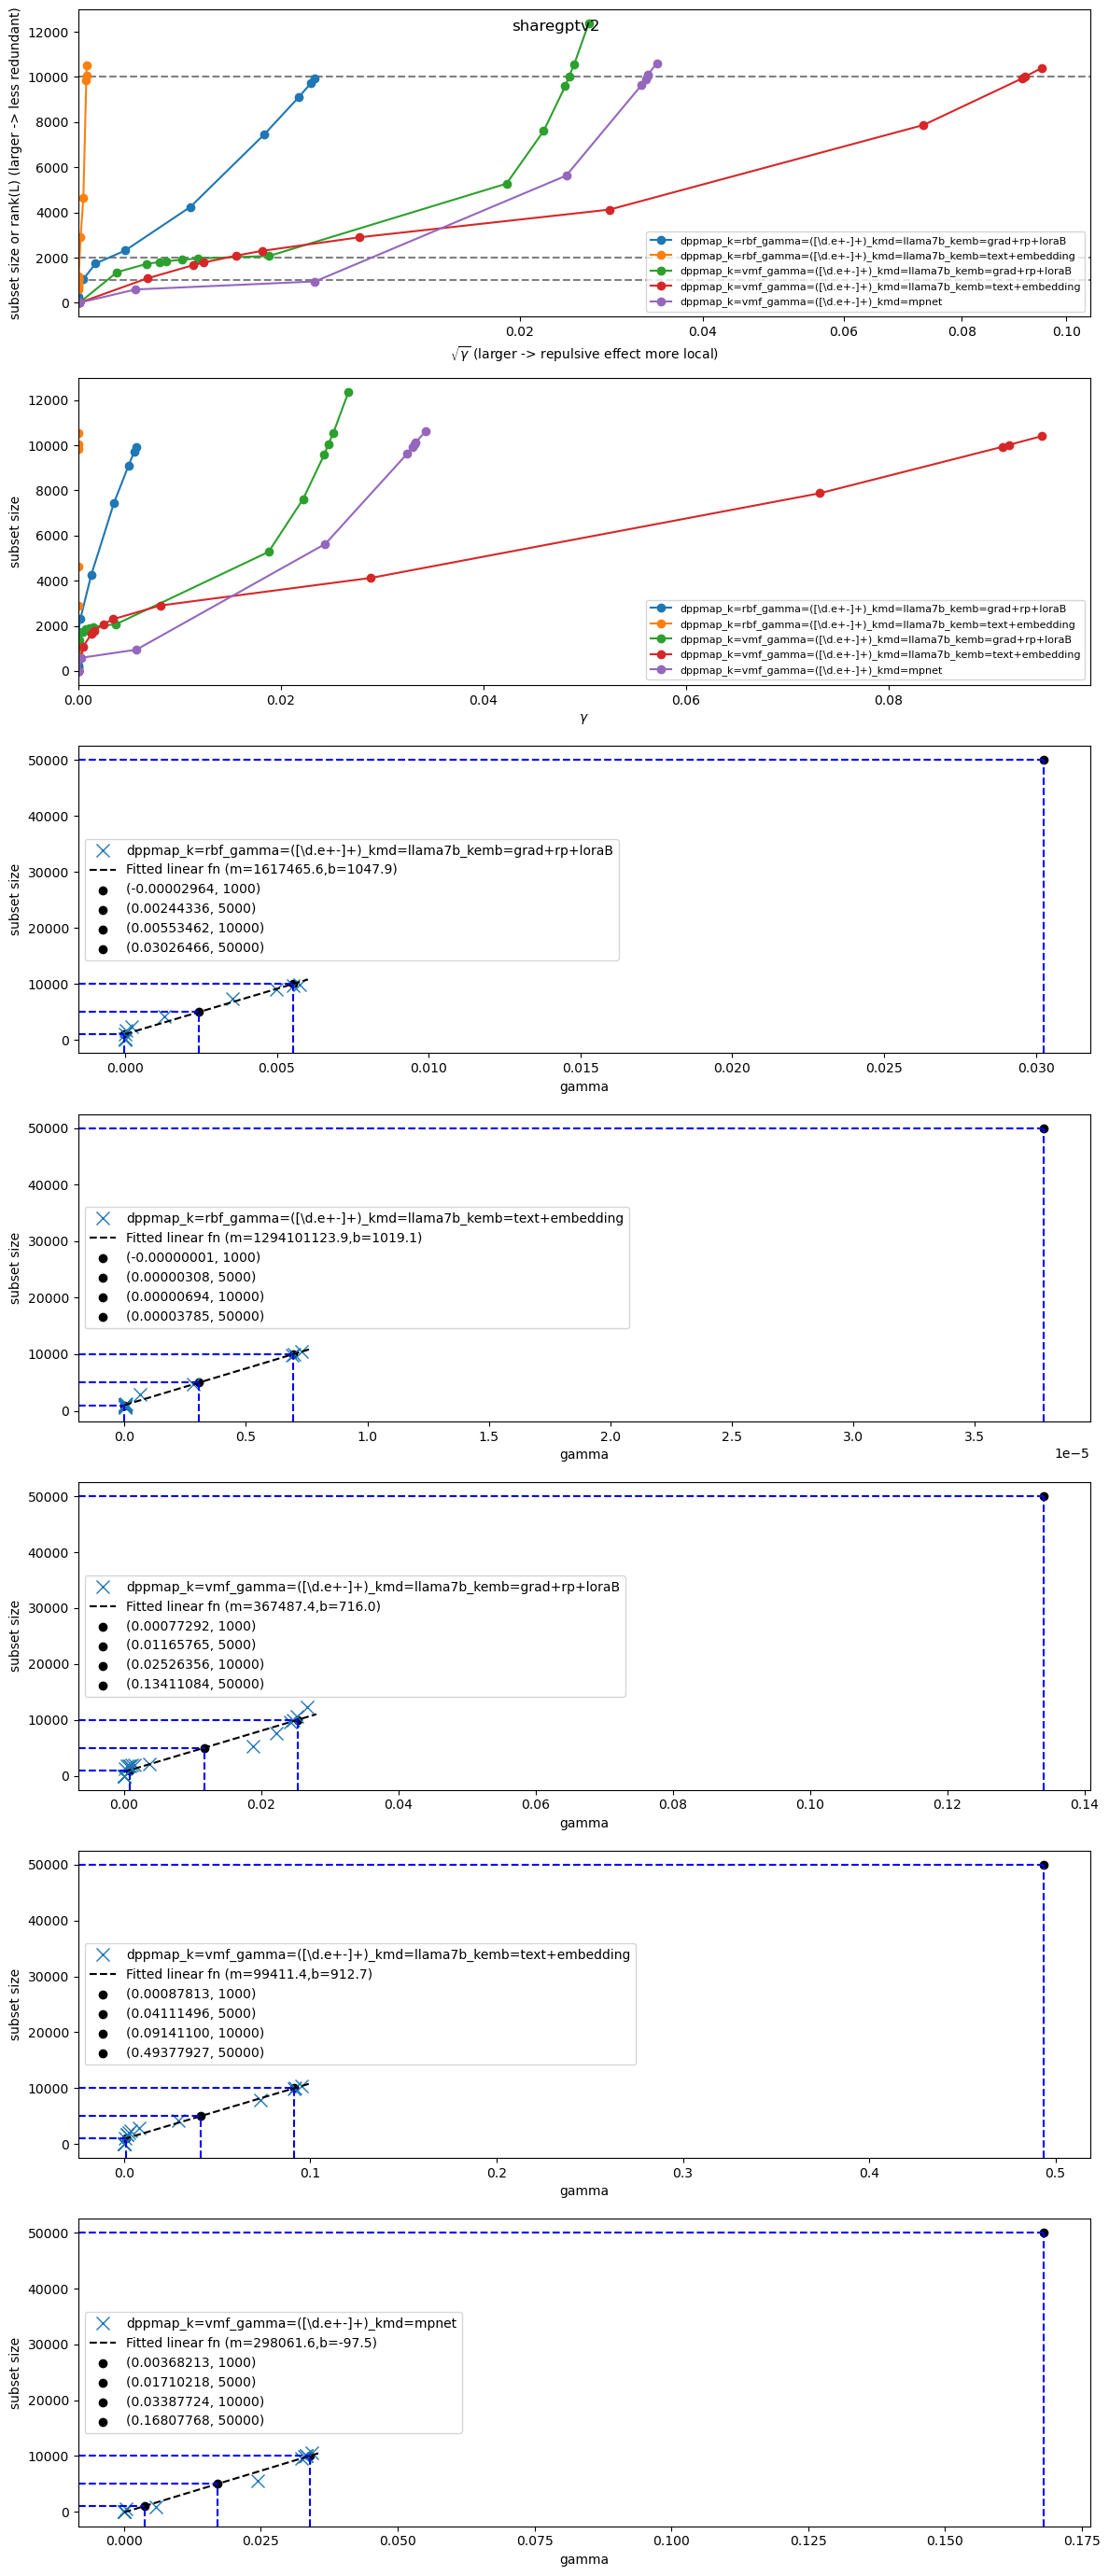

In [80]:

from note_pruning_dpp import plt_subset_size_vs_kernel_params

dataset = 'sharegptv2'
filter_fn = lambda row: 'llama2' not in row['sort_by'] and row['M'] < 20_000
# dataset = 'wizardlm'
# filter_fn = lambda row: 'theta' not in row['sort_by'] and row['M'] < 20_000
# dataset = 'ultrachat15'

fig, axs = plt_subset_size_vs_kernel_params(dataset, save_fig=False, filter_fn=filter_fn)

### Generate curriculum from pre-computed scores (via `note_pruning.py`)

In [ ]:
import itertools
from note_curriculum import (
    get_curriculum_scores,
    get_curriculum,
    generate_curriculum,
    generate_curriculum_forall_scoring_fn,
    scores_path_to_attrs,
    np_random_choice_maximize_noreplacement,
    plt_curriculum,
)
from note_pruning_analysis import assets_dir

# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000; num_epochs = 3
# model_name = 'llama-7b'; dataset = 'sharegpt'; M = 150_000; num_epochs = 3

## mistral+ultrachat
# model_name = 'mistral-7b'; dataset = 'ultrachat200k'; M = 50_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 200_000; num_epochs = 2

## semdedup
# model_name = 'bge-large-en-v1.5'; dataset = 'wizardlm'; M = 100_000; num_epochs = 2
# model_name = 'all-mpnet-base-v2'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2
# model_name = 'all-mpnet-base-v2'; dataset = 'tulu_v1_mix'; M = 150_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2

## starcoder
# M = 25_000; num_epochs=5; model_name = ['codellama-7b', 'all-mpnet-base-v2']; \
#     dataset = ['starcoder_commentinstr_cleaned', 'starcoder_commentinstr']
# M = 50_000; num_epochs=5; model_name = ['codellama-7b', 'all-mpnet-base-v2']; \
#     dataset = ['starcoder_commentinstrv2']

## wizardlm
# model_name = ['llama-7b', 'all-mpnet-base-v2', 'bge-large-en-v1.5']; dataset = ['wizardlm']
# M = 100_000; num_epochs = 2
# M = 50_000; num_epochs = 5
# M = 10_000; num_epochs = 10

## tulu_v1_mix
# model_name = ['llama-7b', 'all-mpnet-base-v2', 'bge-large-en-v1.5']; dataset = ['tulu_v1_mix']
# M = 50_000; num_epochs = 5
# M = 150_000; num_epochs = 3

## tulu_v2, open_orca_slim, sharegptv2
model_name = ['llama-7b', 'llama2-7b', 'all-mpnet-base-v2', 'bge-large-en-v1.5']
# dataset = ['tulu_v2']
dataset = ['open_orca_slim']
# dataset = ['sharegptv2']
M = 50_000; num_epochs = 5



pacing_fn_list = [
#     f'prune_size={M}_ep=1',
    f'prune_size={M}_ep={num_epochs}',
#     f'prune_size={M}_ep=3',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.05',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
]

output_list = generate_curriculum_forall_scoring_fn(
    model_name, dataset, pacing_fn_list, verbose=False)

save inds (length = 50000) to curriculum/llama-7b+lora:r=256:a=256/open_orca_slim/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/inds_prune_size=50000_ep=5.pkl
save inds (length = 50000) to curriculum/llama-7b+lora:r=256:a=256/open_orca_slim/numtoks_input/inds_prune_size=50000_ep=5.pkl
save inds (length = 50000) to curriculum/llama-7b+lora:r=256:a=256/open_orca_slim/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/inds_prune_size=50000_ep=5.pkl
save inds (length = 50000) to curriculum/llama-7b+lora:r=256:a=256/open_orca_slim/numtoks_total_neg/inds_prune_size=50000_ep=5.pkl
save inds (length = 50000) to curriculum/llama-7b+lora:r=256:a=256/open_orca_slim/numtoks_input_neg/inds_prune_size=50000_ep=5.pkl
save inds (length = 50000) to curriculum/llama-7b+lora:r=256:a=256/open_orca_slim/el2n_agg=mean_neg/inds_prune_size=50000_ep=5.pkl
save inds (length = 50000) to curriculum/llama-7b+lora:r=256:a=256/open_orca_slim/logit_margin_neg/inds_prune_size=50000_ep=5.pkl


curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/scores.pkl
fixed exponential pacing startingfrac=0.05, inc=20.0, nsteps=2 
Implies: step_lens=[25000, 25000], stepwise_data_fracs=[0.05, 1.0]
fixed exponential pacing startingfrac=0.05, inc=1.5, nsteps=5 
Implies: step_lens=[10000, 10000, 10000, 10000, 10000], stepwise_data_fracs=[0.05, 0.07500000000000001, 0.1125, 0.16875, 0.253125]
fixed exponential pacing startingfrac=0.05, inc=2.0, nsteps=5 
Implies: step_lens=[10000, 10000, 10000, 10000, 10000], stepwise_data_fracs=[0.05, 0.1, 0.2, 0.4, 0.8]


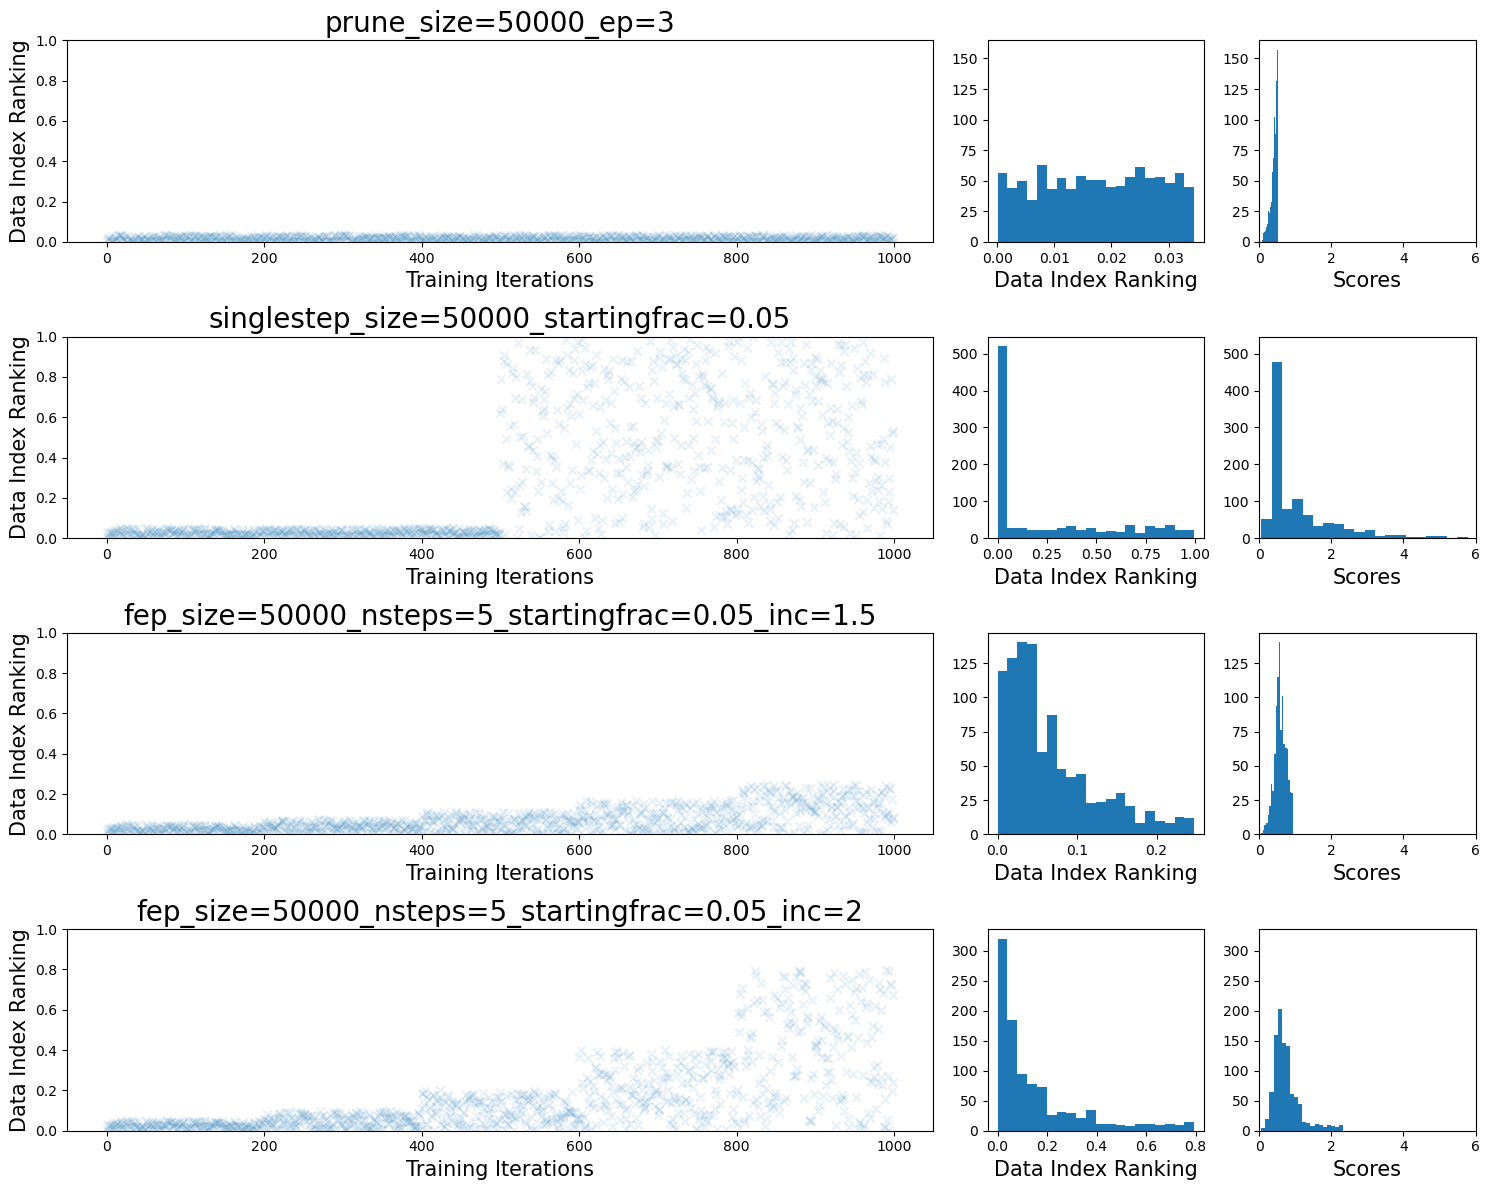

In [4]:
import re
import numpy as np
from note_curriculum import get_curriculum_scores, generate_curriculum, plt_curriculum
import glob
import matplotlib.pyplot as plt

model_name = 'mistral-7b'; dataset = 'ultrachat'; M =  50_000
# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000


paths = glob.glob('curriculum/*/*/*/scores.pkl')
paths = [x for x in paths if 'llama' in x and 'tulu_v1_mix' in x and 'log_prob_neg' in x]
path = paths[0]

verbose = True
print(path)
pacing_fn = f'prune_size={M}_ep=3'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.1'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.2'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.3'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.2_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'

pacing_fn_list = [
    f'prune_size={M}_ep=3',
    f'singlestep_size={M}_startingfrac=0.05',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.2',
#     f'singlestep_size={M}_startingfrac=0.3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=3',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.25'
]



nrows = len(pacing_fn_list)
fig, axs = plt.subplots(nrows, 3, figsize=(15,3*nrows), sharey=False, gridspec_kw={'width_ratios': [2,.5,.5]})

for i, pacing_fn in enumerate(pacing_fn_list):

    plt_kwargs = generate_curriculum(path, pacing_fn, verbose=True, save_output=False)
    output = plt_kwargs.pop('output')
    plt_kwargs.update({'fig': fig, 'axs': axs[i]})
    plt_curriculum(**plt_kwargs)

fig.tight_layout()



save_plt = 0
if save_plt:
    model_name, dataset, scoring_fn = output['model_name'], output['dataset'], output['scoring_fn']
    save_path = os.path.join(
        assets_dir, f'note_curriculum_{model_name}:{dataset}:{scoring_fn}.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)



### main code

In [4]:
import os
import sys
import numpy as np
import time
import re
import random
import json
import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers
import pandas as pd

from note_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_dist_to_cluster_centers,
    sort_dpp_map,
    save_prune_results,
    sort_dpp_map_memefficient,
)
from note_pruning_analysis import get_lm_output
from note_pruning_dpp import torch_vmf_kernel, torch_rbf_kernel
from functools import partial

from transformers import AutoTokenizer

from rosemary import parse_kv_from_string, create_string_from_kv
from note_pruning_analysis import lm_output_dir, get_dataset_token_lengths

import note_pruning_dpp
import note_pruning_clustering

In [5]:
test_run = False
dataset = 'tulu_v1_human_mix'
dataset = 'tulu_v2_human_mix'
dataset = 'flan_v2'
dataset = 'lima'
# dataset = 'flan2022_1m'
# dataset = 'lima'
# dataset = 'ultrachat200k'
# dataset = 'tulu_v1_mix'
dataset = 'wizardlm'
# dataset = 'ultrachat15'
# dataset = 'starcoder_commentinstr_cleaned'

# sort_by = 'random_s=0'
# sort_by = 'kmeansl2_nc=3000'
# sort_by = 'kmeanscd_nc=3000'
# sort_by = 'log_prob'
# sort_by = 'dppmap_k=Kcos'
# sort_by = 'dppmap_k=Kcos1np'
# sort_by = 'el2n'
# sort_by = 'grad_norm'
# sort_by = 'dppmap_k=lin_kmd=mpnet'
# sort_by = 'kmeansl2_emb=grad+rp+loraB_nc=3000'
# sort_by = 'kmeansl2_emb=text+embedding_nc=3000'
# sort_by = 'dppmap_emb=text+embedding_k=Kcos'
# sort_by = 'logit_margin'
# rhov1: mistral-7b base-tuned(ultrachat200k_beforesplitlongconv)
# sort_by = 'rhov1'
# sort_by = 'numtoks'
# sort_by = 'semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200'
sort_by = 'semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1'

# used for generating model output.
# model_name = 'llama-7b'; encode_fn_type = 'sft'
# model_name = 'llama-7b_ft=hmv1'; encode_fn_type = 'sft'
# model_name = 'llama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'
# model_name = 'llama-7b+lima+lora:r=256:a=256'; encode_fn_type = 'sft'
# model_name = 'mistral-7b+lora:r=256:a=256'; encode_fn_type = 'sft'
model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'
# model_name = 'bge-large-en-v1.5'; encode_fn_type = 'input'
# model_name = 'codellama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'

# model_name = 'mistral-7b+lora:r=256:a=256__rho__mistral-7b-ultrachat200k-v1+lora:r=256:a=256'


save_dir = f"data_inds/"
save_dir = os.path.join(save_dir, '' if encode_fn_type=='sft' else encode_fn_type, model_name, dataset)
os.makedirs(save_dir, exist_ok=True) 

print(dataset, model_name, sort_by)
print(save_dir)

wizardlm all-mpnet-base-v2 semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1
data_inds/input/all-mpnet-base-v2/wizardlm


In [6]:
d = get_lm_output(dataset, model_name, encode_fn_type=encode_fn_type, return_text_embedding=True)
if test_run:
    d = {k: v[:1000] for k, v in d.items()}
    
# some entries are nan, impute with mean value.
N = d['text_embedding'].shape[0]
print(N)

143000


In [14]:
## the copy in `note_pruning.py` is most up to date
from note_pruning import parse_sort_by_and_compute_dppmap

pkl_extra = {}
inds = None

# sort_by = 'log_prob'
# sort_by = 'dppmapbd_nc=200_k=lin_kmd=mpnet'

# sort_by = 'dppmap_nc=200_k=vmf_gamma=0.3_kmd=mpnet'
# sort_by = 'dppmap_nc=200_k=vmf_gamma=1.0_kmd=mpnet'
# sort_by = 'dppmap_nc=200_k=vmf_gamma=3.0_kmd=mpnet'
# sort_by = 'dppmapbd_nc=200_theta=.5_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b'
# sort_by = 'dppmapbd_nc=200_theta=.3_k=vmf_gamma=3.0_kmd=mpnet_q=ifd_qmd=llama7b+lima'
# sort_by = 'dppmapbd_nc=200_k=vmf_gamma=0.0000015_kmd=mpnet'

# sort_by = 'ifd'
# sort_by = 'dppmap_k=lin_kmd=mpnet'
sort_by = 'dppmap_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b'

# model_name = 'llama-7b+lima+lora:r=256:a=256'; encode_fn_type = 'sft'
# model_name = 'llama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'

# sort_by = 'semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200'


t0 = time.time()
if any(sort_by.startswith(x) for x in [
        'log_prob', 
        'el2n',  # el2n_agg={l2n|mean}
        'logit_margin', 
        'grad',  # grad_{loraB|qkv|all|last}_l2n
    ]):
    if sort_by not in d:
        print(f'sort_by={sort_by} not in model output: ({dataset}, {model_name})')
    S = np.nan_to_num(d[sort_by], nan=np.nanmean(d[sort_by])).squeeze()
elif sort_by.startswith('ifd'):
    print(f'encode_fn_type={encode_fn_type} not used! since sort_by={sort_by}')
    S = note_pruning_dpp.get_ifd_and_pmi(dataset, model_name)['ifd']
elif sort_by.startswith('log_pmi'):
    print(f'encode_fn_type={encode_fn_type} not used! since sort_by={sort_by}')
    S = note_pruning_dpp.get_ifd_and_pmi(dataset, model_name)['log_pmi']
elif sort_by.startswith('random'):
    match = re.search(r's=(\d+)', sort_by)
    seed = int(match.group(1))
    np.random.seed(seed)
    S = np.random.rand(N)
    assert(S.shape == np.unique(S).shape)
if sort_by.startswith('kmeans'):
    dist_fn = 'l2' if sort_by.startswith('kmeansl2') else 'cd'
    match = re.search(r'nc=(\d+)', sort_by)
    n_clusters = int(match.group(1)) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    print(f'Running kmeans(n_clusters={n_clusters}) {{ {embed_type} }} to compute {"euclidean" if dist_fn == "l2" else "cosine"} distance to cluster centers.')
    S, kms = sort_kmeans_dist_to_cluster_centers(emb, n_clusters, dist_fn=dist_fn)
    pkl_extra['kmeans'] = kms
elif sort_by.startswith('semdedup'):
    kvs = parse_kv_from_string(sort_by)
    md = kvs['md']
    if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
        (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
        (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
        (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')) or \
        (md == 'codellama7b' and not model_name.lower().startswith('codellama-7b')):
        raise ValueError(f'md={md} does not match with model_name={model_name}')
    clustering_fn = create_string_from_kv(
        {k: v for k, v in kvs.items() if k in ['cl', 'nc', 'bsz', 'ms', 'emb']})
    dist = kvs['dist']
    assert(dist in ['cd', 'l2'])
    embed_type = re.sub(r'[+]', '_', kvs['emb'])
    save_dir_clustering = os.path.join('clustering', encode_fn_type, model_name, dataset, clustering_fn)
    os.makedirs(save_dir_clustering, exist_ok=True)
    # normalize embeddings to unit norm if the model that generated the embeddings does the 
    # same, e.g., mpnet, bge, or if using spherical kmeans clustering.
    if any(x in model_name for x in ['mpnet', 'bge']) or 'kmeansfaisscd' in clustering_fn:
        normalize_embeddings = True
    else:
        normalize_embeddings = False
    kwargs = {
        'model_name': model_name,
        'dataset': dataset,
        'encode_fn_type': encode_fn_type,
        'clustering_fn': clustering_fn,
        'embed_type': embed_type,
        'normalize_embeddings': normalize_embeddings,
        'first_N': None,
        'save_dir': save_dir_clustering,
    }
    print(f'Calling note_pruning_clustering.main with kwargs={json.dumps(kwargs, indent=4)}')
    X, Y, C = note_pruning_clustering.main(**kwargs)
    print('Apply SemDeDup to discard duplicates.')
    S = note_pruning_clustering.semdedup(X, Y, dist=dist, device='cuda')
elif sort_by.startswith('dedup'):
    kvs = parse_kv_from_string(sort_by)
    md = kvs['md']
    if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
        (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
        (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
        (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')) or \
        (md == 'codellama7b' and not model_name.lower().startswith('codellama-7b')):
        raise ValueError(f'md={md} does not match with model_name={model_name}')
    if md in ['mpnet', 'bge']:
        normalize_embeddings = True
        dist = 'cd'
    else:
        normalize_embeddings = False
        dist = 'l2'
    embed_type = re.sub(r'[+]', '_', kvs['emb'])
    X = d[embed_type]
    Y = np.zeros(X.shape[0])
    S = semdedup(X, Y, dist=dist, device='cpu')
elif sort_by.startswith('dpp_'):
    match = re.search(r'k=(\w+)', sort_by)
    kernel_type = match.group(1) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    emb = d[embed_type]
    log_prob = d['log_prob']
    inds = sort_dpp_map_memefficient(emb, log_prob, kernel_type=kernel_type, torch_compile=False)
elif sort_by.startswith('dppmap_'):
    if 'gamma=auto' in sort_by:
        S, info = parse_sort_by_and_compute_dppmap_autotune_gamma(sort_by, dataset)
        if S is None and info is None:
            # return # in jpt
            pass
    else:
        S, info = parse_sort_by_and_compute_dppmap(sort_by, dataset)
    pkl_extra['info'] = output
elif sort_by.startswith('dppmapbd'):
    kvs = parse_kv_from_string(sort_by)
    md = kvs['kmd']
    if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
        (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
        (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
        (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')):
        raise ValueError(f'md={md} does not match with model_name={model_name}')
    if kvs['k'] == 'vmf':
        kernel_kwargs = {'gamma': kvs['gamma']}
    elif kvs['k'] == 'rbf':
        kernel_kwargs = {'gamma': kvs['gamma']}
    elif kvs['k'] == 'lin':
        kernel_kwargs = {'gamma': kvs.get('gamma', 1.)}
    else:
        kernel_kwargs = {}
    kwargs = {
        'dppmap_type': 'dppmapbd',
        'dataset': dataset,
        'kernel_type': kvs['k'],
        'kernel_embed_model': kvs['kmd'],
        'kernel_embed_type': re.sub(r'[+]', '_', kvs['kemb']) if 'kemb' in kvs else 'text_embedding',
        'kernel_kwargs': kernel_kwargs,
        'quality_score_type': re.sub(r'[+]', '_', kvs['q']) if 'q' in kvs else None,
        'quality_score_embed_model': kvs.get('qmd', None),
        'theta': kvs.get('theta', 0.), # defaults to just diversity no quality
        'device': 'cuda',
        'max_length': 5_000, # per-cluster max length. 
        'run_name': sort_by,
    }
    clustering_fn = create_string_from_kv({
        'cl': kvs.get('cl', 'kmeansfaisscd'),
        'md': kwargs['kernel_embed_model'],
        'emb': kvs['kemb'] if 'kemb' in kvs else 'text+embedding',
        'nc': kvs['nc'],
    })
    save_dir_clustering = os.path.join(
        'clustering', encode_fn_type, model_name, dataset, clustering_fn)
    os.makedirs(save_dir_clustering, exist_ok=True)
    clustering_data_path = os.path.join(save_dir_clustering, 'data.pkl')
    if not os.path.isfile(clustering_data_path):
        normalize_embeddings = True if \
            (any(x in model_name for x in ['mpnet', 'bge']) or 'kmeansfaisscd' in clustering_fn) else False
        kwargs_clustering = {
            'model_name': model_name,
            'dataset': dataset,
            'encode_fn_type': encode_fn_type,
            'clustering_fn': clustering_fn,
            'embed_type': kwargs['kernel_embed_type'],
            'normalize_embeddings': normalize_embeddings,
            'first_N': None,
            'save_dir': save_dir_clustering,
        }
        print(f'Calling note_pruning_clustering.main with kwargs={json.dumps(kwargs_clustering, indent=4)}')
        X, Y, C = note_pruning_clustering.main(**kwargs_clustering)
    else:
        with open(clustering_data_path, 'rb') as f:
            data = pickle.load(f)
        Y = data['Y']
    print(f'Calling note_pruning_dpp.compute_dppmap with kwargs={json.dumps(kwargs, indent=4)}')
    kwargs.update({'Y': Y})
    S, output = note_pruning_dpp.compute_dppmap(**kwargs)
elif sort_by.startswith('rho'):
    if sort_by == 'rhov1':
        model_names = ['mistral-7b+lora:r=256:a=256',
                       'mistral-7b-ultrachat200k-v1+lora:r=256:a=256']
        assert(model_name == model_names[0])
    else:
        raise ValueError(f'sort_by={sort_by} not implemented.')
    assert(len(model_names) == 2)
    ds = []
    for x in model_names:
        ds.append(get_lm_output(dataset, x, return_text_embedding=False, fill_nan=False))
    ks = [set(d.keys()) for d in ds]
    ks = ks[0] & ks[1]
    for k in ks:
        S0 = ds[0][k]
        S1 = ds[1][k]
        # handle nan entries properly.
        nan_mask = np.logical_or(np.isnan(S0), np.isnan(S1))
        S = np.subtract(S0, S1)
        S[nan_mask] = np.nan
        S = S.squeeze()
        save_prune_results(save_dir, None, S, {}, f'{sort_by}_{k}', model_name, dataset)
elif sort_by.startswith('numtoks'):
    if model_name.lower().startswith('llama'):
        tokenizer = AutoTokenizer.from_pretrained('results/baselines/huggyllama/llama-7b', use_fast=False)
    elif model_name.lower().startswith('codellama'):
        tokenizer = AutoTokenizer.from_pretrained('results/baselines/codellama/CodeLlama-7b-hf')
    elif model_name.lower().startswith('mistral'):
        tokenizer = AutoTokenizer.from_pretrained('results/baselines/mistralai/Mistral-7B-v0.1', use_fast=False)
    else:
        raise ValueError('Need to supply appropriate tokenizer to count token lengths,')
    d = get_dataset_token_lengths(dataset, tokenizer)

    d['total_len'] = d['input_len'] + d['output_len']
    for k in ['input', 'output', 'total']:
        S = d[f'{k}_len']
        save_prune_results(save_dir, None, S, {}, f'{sort_by}_{k}', model_name, dataset)

        
t1 = time.time()
print(f'Rank datapoints with {sort_by} took {t1-t0:.2f} seconds.')


Calling note_pruning_dpp.compute_dppmap with kwargs={
    "dppmap_type": "dppmap",
    "dataset": "wizardlm",
    "kernel_type": "vmf",
    "kernel_embed_model": "mpnet",
    "kernel_embed_type": "text_embedding",
    "kernel_kwargs": {
        "gamma": 0.035
    },
    "quality_score_type": "log_pmi",
    "quality_score_embed_model": "llama7b",
    "theta": 0.0,
    "device": "cuda",
    "max_length": 20000,
    "run_name": "dppmap_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b"
}


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Loading cached processed dataset at /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-4aae7d7d0cb443eb_*_of_00008.arrow

KeyboardInterrupt



In [13]:

# from note_pruning import save_prune_results
if not any(sort_by.startswith(x) for x in ['rho', 'numtoks']):
    save_prune_results(save_dir, inds, S, pkl_extra, sort_by, model_name, dataset)

save inds (length = 8380) to data_inds/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_incr.pkl
save inds (length = 8380) to data_inds/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_decr.pkl


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-1c0d5cd9d22521b9/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_beg_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_end_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_partition=1:10_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_partition=10:10_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_partition=2:3_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-1c0d5cd9d22521b9/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_random_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_beg_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_end_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_partition=1:10_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_partition=10:10_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_partition=2:3_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_random_num=400.txt completed!


In [12]:
save_dir

'data_inds/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned'

In [11]:
s = 'def AdvectionRK4(particle, fieldset, time):\n(u1, v1) = fieldset.UV[particle]\n(lon1, lat1) = (particle.lon + u1 * 0.5 * particle.dt, particle.lat + v1 * 0.5 * particle.dt)\n(u2, v2) = fieldset.UV[time + 0.5 * particle.dt, particle.depth, lat1, lon1, particle]\n(lon2, lat2) = (particle.lon + u2 * 0.5 * particle.dt, particle.lat + v2 * 0.5 * particle.dt)\n(u3, v3) = fieldset.UV[time + 0.5 * particle.dt, particle.depth, lat2, lon2, particle]\n(lon3, lat3) = (particle.lon + u3 * particle.dt, particle.lat + v3 * particle.dt)\n(u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3, particle]\nparticle.lon += (u1 + 2 * u2 + 2 * u3 + u4) / 6.0 * particle.dt\nparticle.lat += (v1 + 2 * v2 + 2 * v3 + v4) / 6.0 * particle.dt'
print(s)

def AdvectionRK4(particle, fieldset, time):
(u1, v1) = fieldset.UV[particle]
(lon1, lat1) = (particle.lon + u1 * 0.5 * particle.dt, particle.lat + v1 * 0.5 * particle.dt)
(u2, v2) = fieldset.UV[time + 0.5 * particle.dt, particle.depth, lat1, lon1, particle]
(lon2, lat2) = (particle.lon + u2 * 0.5 * particle.dt, particle.lat + v2 * 0.5 * particle.dt)
(u3, v3) = fieldset.UV[time + 0.5 * particle.dt, particle.depth, lat2, lon2, particle]
(lon3, lat3) = (particle.lon + u3 * particle.dt, particle.lat + v3 * particle.dt)
(u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3, particle]
particle.lon += (u1 + 2 * u2 + 2 * u3 + u4) / 6.0 * particle.dt
particle.lat += (v1 + 2 * v2 + 2 * v3 + v4) / 6.0 * particle.dt
